In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
deep_dipole_coordinates = (
    [ 300,  750, 1200, 300, 1200, 1750],  # µm
    [ 300, 1000, 1700, 1600, 300, 1000],  # µm
    [-600, -600, -600, -600, -600, -600],  # µm
)
deep_dipole_moments = mg.angles_to_vector(
    inclination=[-90, 90, -90, 90, 90, -90],
    declination=[0, 0, 0, 0, 0, 0],
    amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
)

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 70
sourcers2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2)]),  # µm
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2)]),  # µm
    np.random.randint(-20, -1, sourcers1+sourcers2),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2)]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2)]),
    amplitude=abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14,
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print()

In [5]:
bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 23.05 23.19 23.33 23.46 ... 3.72 3.641 3.564 3.488

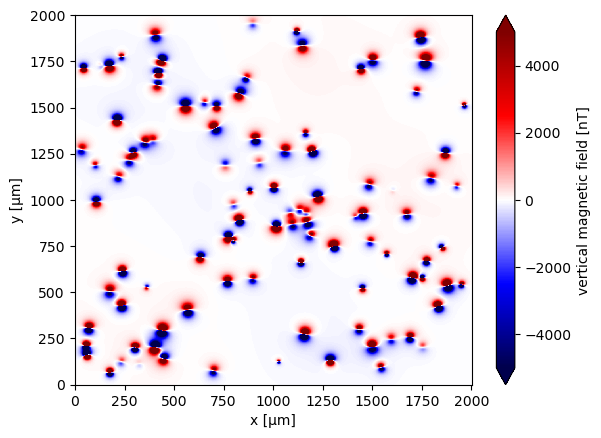

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [7]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

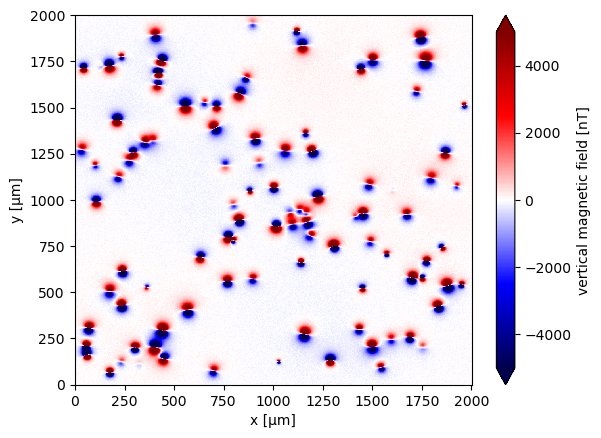

In [8]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Polynomial fitting to suppress high frequency noise
2. Upward continue the data to suppress high frequency noise
3. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
4. Contrast stretch the TGA to highlight weaker sources
5. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Polynomial fitting to suppress low frequency noise

In [9]:
trend = vd.Trend(degree=5).fit((coordinates), data.bz.values)
low_frequency_noise = trend.predict(coordinates).reshape(data.bz.shape)

data = data.assign(low_freq=(['y','x'],low_frequency_noise))
data.low_freq.attrs = {"long_name": "low-frequency noise", "units": "nT"}

residual = data.bz.values - data.low_freq.values
data = data.assign(residual=(['y','x'],residual))
data.residual.attrs = {"long_name": "residual anomaly", "units": "nT"}

data

<xarray.Dataset>
Dimensions:   (y: 1001, x: 1001)
Coordinates:
  * x         (x) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y         (y) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z         (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz        (y, x) float64 38.28 -28.81 60.85 70.49 ... -63.6 -13.31 -26.64
    low_freq  (y, x) float64 -233.8 -230.6 -227.4 -224.2 ... 196.4 197.2 198.0
    residual  (y, x) float64 272.1 201.8 288.2 294.7 ... -260.0 -210.5 -224.6

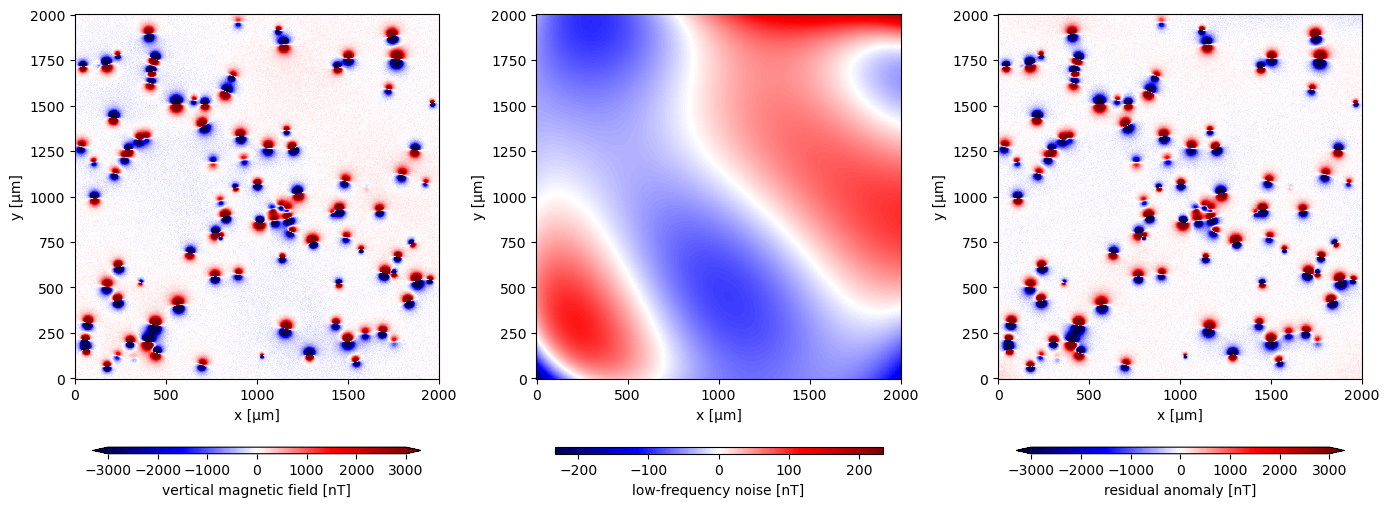

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(14, 14))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.05, shrink=0.9)
for field, ax in zip(["bz", "low_freq", "residual"], axes.ravel()):
    vmax, vmin = None, None
    if field != "low_freq":
        vmax=+3000
        vmin=-3000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

## 2. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [11]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.residual, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 77.54 94.33 106.4 113.6 ... -9.106 3.662 22.58

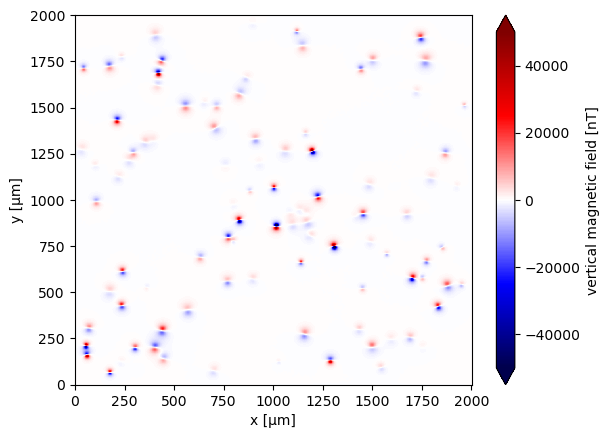

In [12]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 3. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [13]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 77.54 94.33 106.4 113.6 ... -9.106 3.662 22.58
    tga      (y, x) float64 17.63 17.12 16.22 15.01 ... 20.24 20.85 20.89 19.26
    x_deriv  (y, x) float64 8.392 7.216 4.807 2.765 ... 2.997 5.105 7.923 9.461
    y_deriv  (y, x) float64 13.94 12.34 11.35 11.07 ... 17.26 17.0 16.42 15.27
    z_deriv  (y, x) float64 -6.77 -9.433 -10.55 -9.757 ... 10.94 10.2 6.943

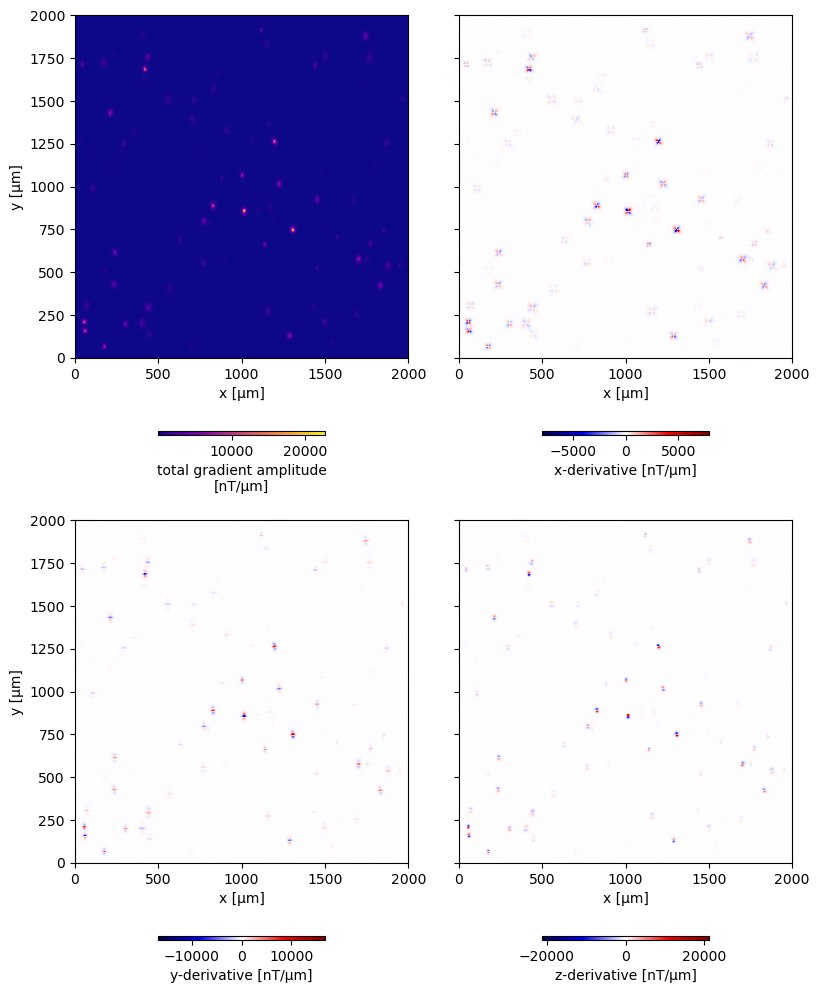

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 4. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [15]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

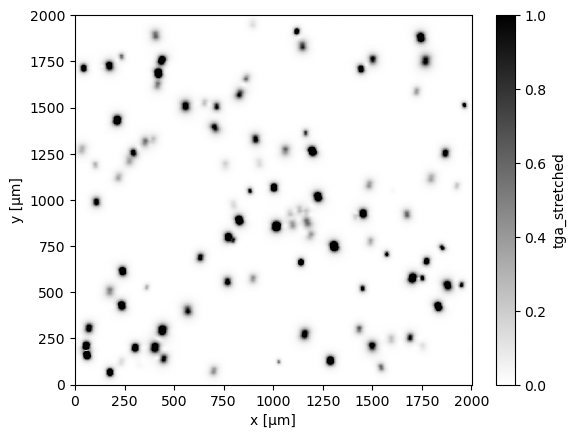

In [16]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 5. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [17]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[15, 50],
    size_increment=1.3,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows


In [18]:
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  98


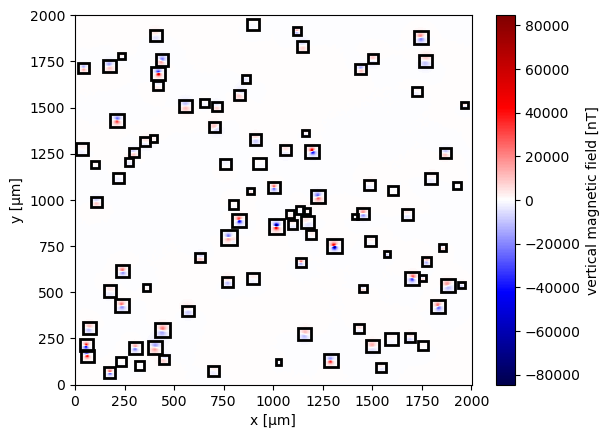

In [19]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [22]:
positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)

print()
print("Dipole moments estimated:", positions.shape[1])

R²: 0.9991065487286304 and SNR: 30.52383190455892
R²: 0.9991200084803629 and SNR: 30.56949228372691
R²: 0.999110529740987 and SNR: 30.55736559869356
R²: 0.9993755893450248 and SNR: 32.04533888982185
R²: 0.999140337460497 and SNR: 30.661885629935448
R²: 0.9988059271524689 and SNR: 29.23539790374796
R²: 0.9996416954103656 and SNR: 34.47037797735887
R²: 0.9995116441467709 and SNR: 33.264598312596334
R²: 0.9996350659075226 and SNR: 34.44120696950254
R²: 0.999635465012543 and SNR: 34.38847709966772
R²: 0.9988048632974137 and SNR: 29.304717003676778
R²: 0.9996603576621833 and SNR: 34.69344198820659
R²: 0.9994951920180185 and SNR: 33.10227806713697
R²: 0.9994244415730156 and SNR: 32.4784018239757
R²: 0.9997968405641959 and SNR: 36.99848693943824
R²: 0.9393754395011815 and SNR: 12.183717921996395
R²: 0.998383320278473 and SNR: 27.915442041176988
R²: 0.999555251723882 and SNR: 33.52134784487233
R²: 0.9982214971899348 and SNR: 27.565765705427626
R²: 0.9990733187663268 and SNR: 30.490636751129287

Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [23]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.38532557,  0.3854316 ,  0.38890006,  0.36236161,  0.38992714,
        0.43049129,  0.30672503,  0.32764518,  0.26640134,  0.32681314,
        0.42719394,  0.3259053 ,  0.36526164,  0.33157168,  0.33955718,
        0.58915647,  0.21185436,  0.33358177,  0.31377585, -0.04318531,
        0.35533894,  0.25077782,  0.21876333,  0.32161591,  0.34953233,
        0.0733627 ,  0.34493969,  0.68684064,  0.50217953,  0.22335889,
        0.42155536,  0.19625589,  0.40547884,  0.23739903,  0.21384577,
        0.35890056,  0.22649992,  0.10205587,  0.2011746 ,  0.24547286,
        0.22787545,  0.32690833, -1.11318741,  0.05067184,  0.35379648,
        0.23091559,  1.19789756,  0.14513178,  0.34717469,  0.88482722,
        0.21699123,  0.1475598 ,  0.21370184,  0.19954364,  0.06362844,
       -0.02783794,  0.46571612,  0.39009726,  0.21301801,  0.02410001,
        0.17219911,  0.62072515,  0.48460365,  3.62619028,  0.16994726,
       -0.30014544, -1.77745876,  0.92738018,  4.22127043,  0.21

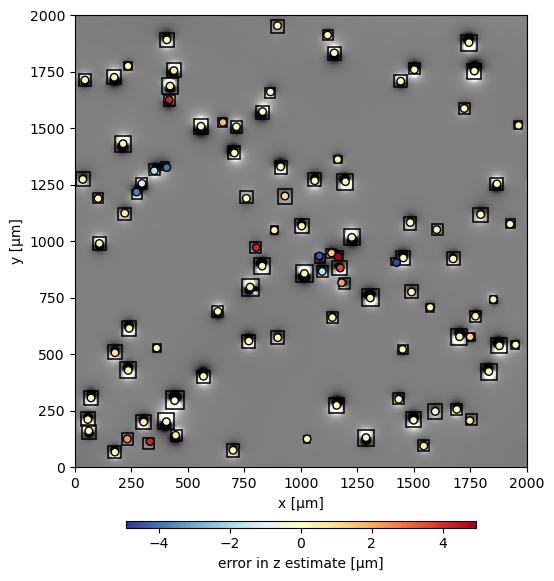

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [25]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, sigmas, true, r2, SNR in zip(estimated_dipole_moments, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    print(f"R²   : {r2:.5f} ")
    print(f"SNR  : {SNR:.5f} ")
    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    print()

Inclination: 14.438811033761407 | 14.44616635106111 ± 0.033
Declination: -13.026214317497882 | -13.019637458926224 ± 0.047
Amplitude  : 1.639212e-12 | 1.542347e-12 ± 1.2e-15
R²   : 0.99911 
SNR  : 30.52383 
Direction Misfit  : 0.01° 
Magnetic Moment Misfit  : 5.91 %

Inclination: -6.385105554205018 | -6.39888245125869 ± 0.035
Declination: -20.26401888498568 | -20.258704289004232 ± 0.049
Amplitude  : 1.286446e-12 | 1.210405e-12 ± 1.0e-15
R²   : 0.99912 
SNR  : 30.56949 
Direction Misfit  : 0.01° 
Magnetic Moment Misfit  : 5.91 %

Inclination: 13.351503366259019 | 13.398485306327425 ± 0.033
Declination: -176.8453384977992 | -176.92481083744832 ± 0.046
Amplitude  : 1.694328e-12 | 1.592142e-12 ± 1.2e-15
R²   : 0.99911 
SNR  : 30.55737 
Direction Misfit  : 0.09° 
Magnetic Moment Misfit  : 6.03 %

Inclination: 8.359439567722045 | 8.282963221731636 ± 0.030
Declination: -12.782156990100411 | -12.711247571429773 ± 0.042
Amplitude  : 1.343946e-12 | 1.273493e-12 ± 9.1e-16
R²   : 0.99938 
SNR  : 3

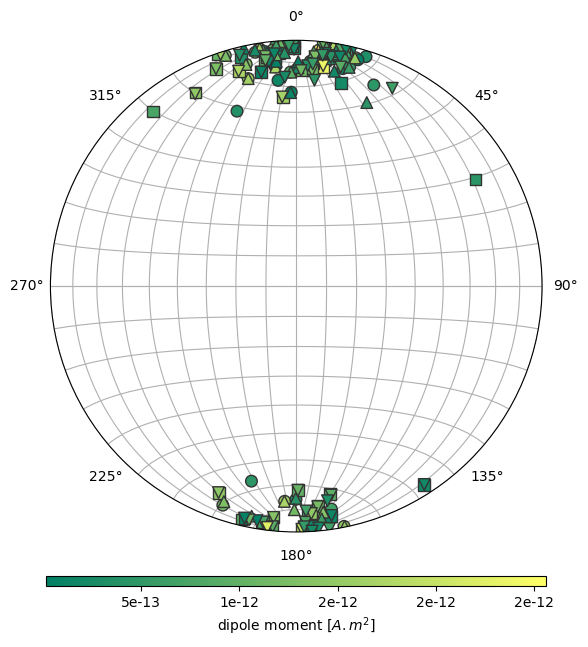

In [26]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

# Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [27]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

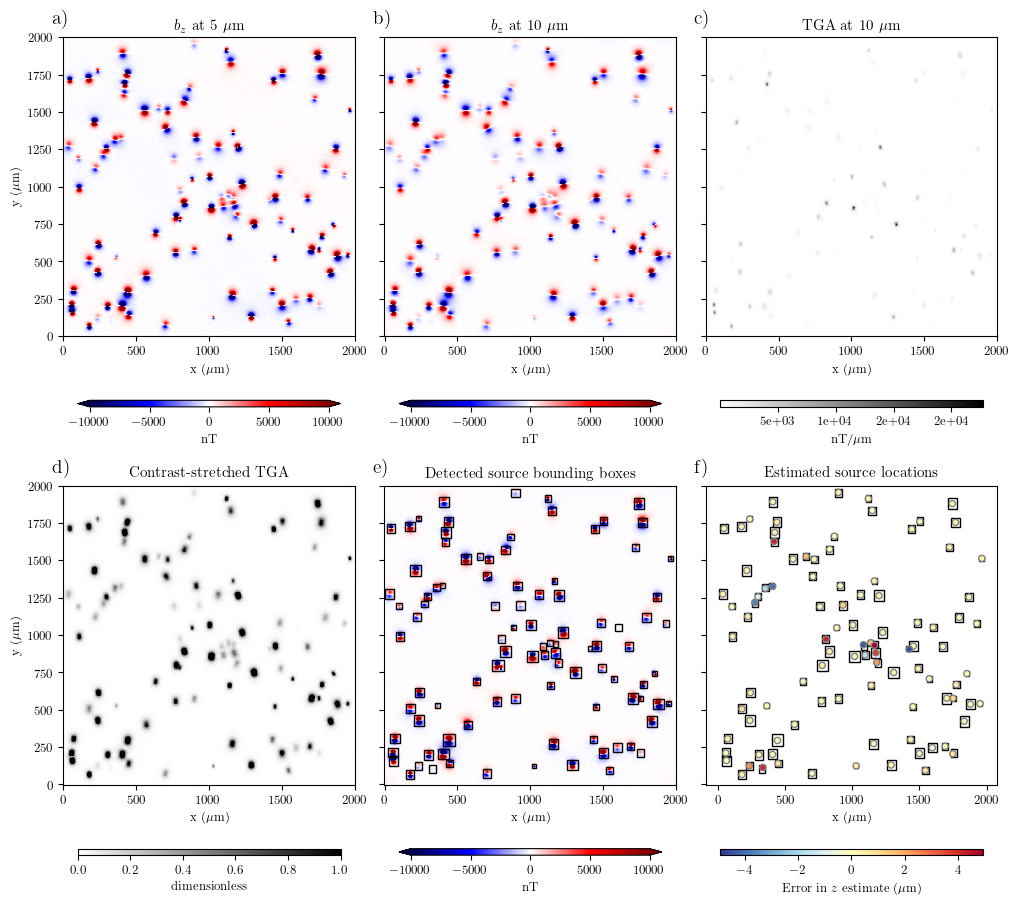

In [28]:
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("auto")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("auto")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.residual.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   

    ax = axes[5]  
    ax.set_aspect("auto")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(z_difference)
    tmp = ax.scatter(*positions[:2], c=z_difference, s=20, cmap="RdYlBu_r", vmin=-scale, vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="Error in $z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    
    fig.savefig(fig_dir / "complex-synthetic-data.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

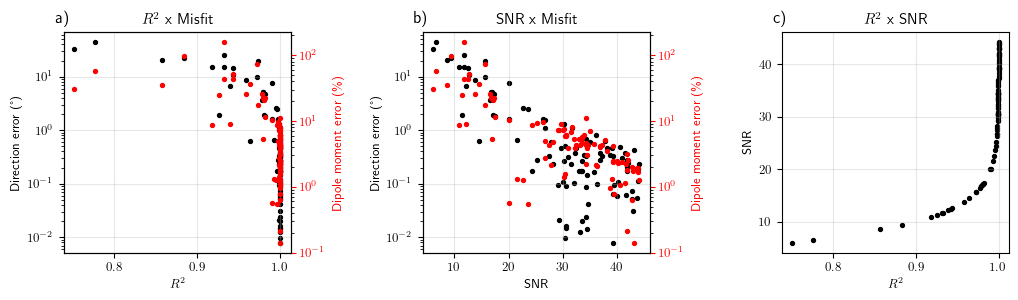

In [29]:
with plt.rc_context(mpl_rc):
    size=8
    fig, axes = plt.subplots(1,3, figsize=(10, 2.8))    

    axes = axes.ravel()
    ax = axes[0]
    ax.scatter(calculated_r2, direction_misfit, color='k', s=size)
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('$R^2$')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_r2, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[1]
    ax.scatter(calculated_SNR, direction_misfit, color='k', s=size, label='direction (°)')
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('SNR')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_SNR, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_xlabel('SNR')
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[2]
    ax.scatter(calculated_r2, calculated_SNR, color='k', s=size)
    ax.set_xlabel('$R^2$')
    ax.set_ylabel('SNR')

    titles = [r'$R^2$ x Misfit', r'SNR x Misfit', r'$R^2$ x SNR']
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_aspect("auto")
        ax.grid(alpha=0.3, which='major')
        ax.set_title(title)




    plt.tight_layout(pad=0, h_pad=0, w_pad=2)
    
    fig.savefig(fig_dir / "complex-synthetic-fitting-test.png", dpi=300, facecolor='w', bbox_inches='tight')

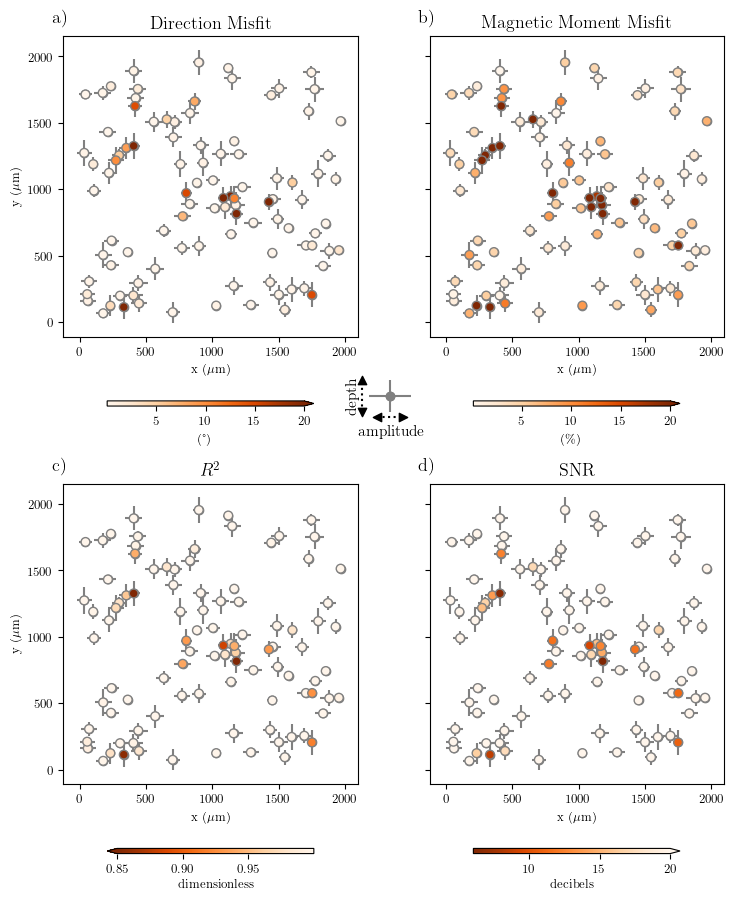

In [30]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 2, figsize=(8, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"$R^2$", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")

    scale = 0.85
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="Oranges_r", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs, extend='min') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"SNR", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    
    scale = 20
    tmp = ax.scatter(*positions[:2], c=calculated_SNR, s=40, cmap="Oranges_r", edgecolor='gray', vmax=scale)
    fig.colorbar(tmp, ax=ax, label="decibels", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
#         ax.scatter(*dipole_coordinates[:2], color='k', marker='x', zorder=-1)
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    
    
    left, bottom, width, height = [0.45, 0.52, 0.09, 0.09]
    ax5 = fig.add_axes([left, bottom, width, height])
    ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
                 fmt='o', zorder=0, color='gray')
    ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
    ax5.set_ylim(-1.0, 1.5)
    ax5.set_xlim(-0.6, 1.1)

    ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
    ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
    ax5.scatter(-0.15, -0.0, marker='v', color='k')
    ax5.scatter(-0.15, 1.0, marker='^', color='k')

    ax5.scatter(0.2,-0.15, marker='<', color='k')
    ax5.scatter(0.8,-0.15, marker='>', color='k')

    ax5.text(-0.25, -0.7, 'amplitude', color='k', fontsize=11)
    ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

    ax5.set_title('', loc='left')
    # Eliminate upper and right axes
    ax5.spines['right'].set_color('none')
    ax5.spines['top'].set_color('none')
    ax5.spines['bottom'].set_color('none')
    ax5.spines['left'].set_color('none')
    ax5.xaxis.set_ticks([])
    ax5.yaxis.set_ticks([])
    
    fig.savefig(fig_dir / "complex-synthetic-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()


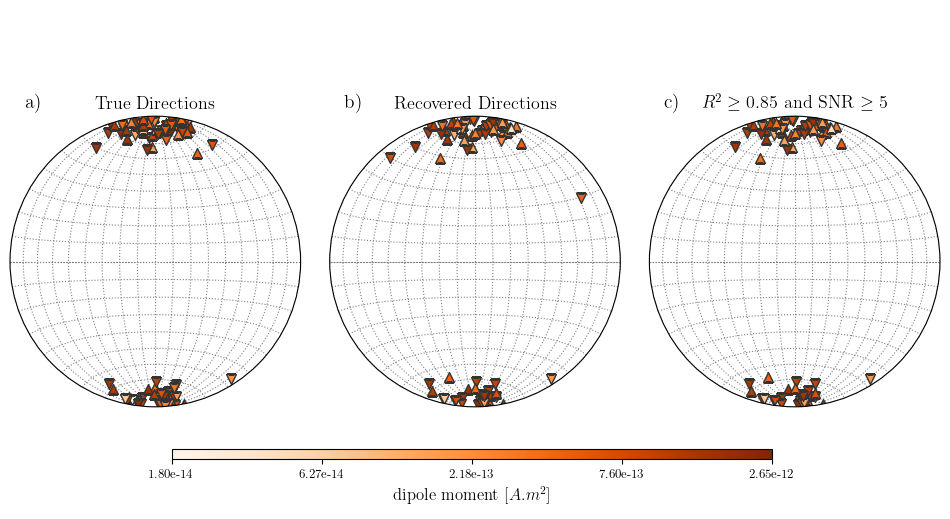

In [31]:
with plt.rc_context(mpl_rc):
    fig, axes = mplstereonet.subplots(1, 3, figsize=(12, 5))

    estimated = mg.vector_to_angles(estimated_dipole_moments)
    true = mg.vector_to_angles(dipole_moments)
    scatter_args = dict(
        vmin=np.min([np.log10(np.min(estimated[2])), np.log10(np.min(true[2]))]),
        vmax=np.max([np.log10(np.max(estimated[2])), np.log10(np.max(true[2]))]),
        cmap="Oranges",
        edgecolors="#333333",
        linewidths=1,
        s=50,
        zorder=2,
    )

    
    ticks=np.linspace( np.min([np.log10(np.min(estimated[2])), np.log10(np.min(true[2]))]),
                       np.max([np.log10(np.max(estimated[2])), np.log10(np.max(true[2]))]), 5)
    
    ax = axes[0]
    for i in range(len(dipole_moments)):
        true = mg.vector_to_angles(dipole_moments[i])
        pos_inc = true[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
            c=np.log10(true[2][pos_inc]),
            marker="^",
            **scatter_args,
        )
        tmp = ax.scatter(
            *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
            c=np.log10(true[2][~pos_inc]),
            marker="v",
            **scatter_args,
        )

    ax = axes[1]       
    for i in range(len(estimated_dipole_moments)):
        estimated = mg.vector_to_angles(estimated_dipole_moments[i])
        pos_inc = estimated[0] > 0
        tmp = ax.scatter(
            *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
            c=np.log10(estimated[2][pos_inc]),
            marker="^",
            **scatter_args,
        )
        tmp = ax.scatter(
            *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
            c=np.log10(estimated[2][~pos_inc]),
            marker="v",
            **scatter_args,
        )

    ax = axes[2]
    count_r2 = 0         
    for i in range(len(calculated_r2)):
        if calculated_r2[i] >= 0.85 and calculated_SNR[i] >= 5:
#         if calculated_SNR[i] >= 20:
            count_r2 += 1
            estimated = mg.vector_to_angles(estimated_dipole_moments[i])
            pos_inc = estimated[0] > 0
            tmp = ax.scatter(
                *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
                c=np.log10(estimated[2][pos_inc]),
                marker="^",
                **scatter_args,
            )
            tmp = ax.scatter(
                *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
                c=np.log10(estimated[2][~pos_inc]),
                marker="v",
                **scatter_args,
            )

    tick_labels = []
    for i in (ticks):
        tick_labels.append("{:.2e}".format(10**i))


    clb = fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.26, 0.10, 0.5, 0.02]), 
        orientation="horizontal", 
        format="%.2e",
        ticks = ticks)
    clb.set_label(label="dipole moment [$A.m^2$]", fontsize=12)
    clb.set_ticklabels(tick_labels)

#     fig.colorbar(
#         tmp, 
#         cax=fig.add_axes([0.3, 0.1, 0.4, 0.02]), 
#         orientation="horizontal",
#         format="%.0e"
#     ).set_label(label="dipole moment [$A.m^2$]", size=12)

    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_azimuth_ticks([])
        ax.grid(linestyle=':', color='gray')
        ax.set_title(title, fontsize=13)
    fig.subplots_adjust(wspace=0.1)
    # plt.tight_layout(pad=0, h_pad=0, w_pad=0.7)
    
    fig.savefig(fig_dir / "complex-synthetic-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()
